In [4]:
from imutils import face_utils
from imutils.video import VideoStream
import argparse
import imutils
import dlib
import cv2
import time
import pandas as pd
import random
from keras.utils.np_utils import to_categorical
import numpy as np
from PIL import Image as im
from matplotlib import pyplot as plt

In [9]:
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}

def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    print ('Disgust classified as Angry')
    y_train.loc[y_train == 1] = 0
    classes.remove('Disgust')
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

def load_data(sample_split=0.3, usage='Training', classes=['Angry','Happy'], filepath='../../fer20131.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    frames = []
    classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    ## reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

In [10]:
emo = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

X_test, y_test = load_data(sample_split=1.0, classes=emo, usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,classes=emo, usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,classes=emo, usage= 'PublicTest')


Disgust classified as Angry


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Disgust classified as Angry
Disgust classified as Angry


In [11]:
def save_data(X_test, y_test, fname=''):
    """
    The function stores loaded data into numpy form for further processing
    """
    np.save( 'X_test' + fname, X_test)
    np.save( 'y_test' + fname, y_test)
save_data(X_test, y_test,"_privatetest6_100pct")
X_fname = 'X_test_privatetest6_100pct.npy'
y_fname = 'y_test_privatetest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print(zip(labels, counts))


Private test set


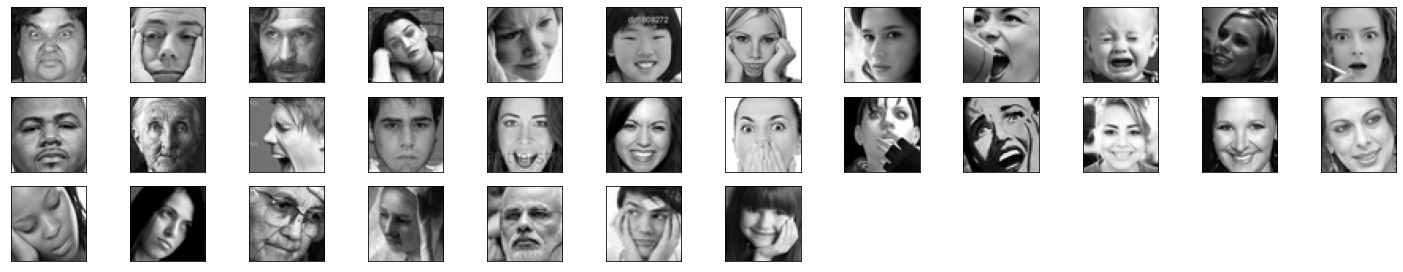

In [12]:
def overview(start, end, X):
    """
    The function is used to plot first several pictures for overviewing inputs format
    """
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=plt.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
    
overview(0, 30, X)

In [13]:
y_train_labels  = [np.argmax(lst) for lst in y_train]
y_public_labels = [np.argmax(lst) for lst in y_val]
y_private_labels = [np.argmax(lst) for lst in y_test]

In [144]:
#%%capture output

# Final Model Architecture:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks

# kaggle : https://www.kaggle.com/ashishpatel26/tutorial-facial-expression-classification-keras/notebook
# + article https://www.cv-foundation.org//openaccess/content_iccv_2015_workshops/w11/papers/Hu_When_Face_Recognition_ICCV_2015_paper.pdf

modelN = models.Sequential()
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
#modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
#modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
#modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
#modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
#modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
#modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(6, activation='softmax'))

# optimizer:
modelN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', "mae"])
print ('Training....')


#fit
nb_epoch = 32
batch_size = 128

# This callback will stop the training when there is no improvement in
# the val_loss for five consecutive epochs
earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)


modelF = modelN.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,
          validation_data=(X_val, y_val), shuffle=True, verbose=1, callbacks=[earlyStopping])

Training....
Epoch 1/32
225/225 [==============================] - 34s 148ms/step - loss: 1.6662 - accuracy: 0.3059 - mae: 0.2626 - val_loss: 1.4984 - val_accuracy: 0.4062 - val_mae: 0.2396
Epoch 2/32
225/225 [==============================] - 33s 148ms/step - loss: 1.4283 - accuracy: 0.4370 - mae: 0.2302 - val_loss: 1.4085 - val_accuracy: 0.4558 - val_mae: 0.2172
Epoch 3/32
225/225 [==============================] - 33s 148ms/step - loss: 1.3046 - accuracy: 0.4887 - mae: 0.2129 - val_loss: 1.2766 - val_accuracy: 0.5026 - val_mae: 0.2062
Epoch 4/32
225/225 [==============================] - 33s 148ms/step - loss: 1.2126 - accuracy: 0.5272 - mae: 0.1998 - val_loss: 1.2388 - val_accuracy: 0.5171 - val_mae: 0.1980
Epoch 5/32
225/225 [==============================] - 34s 149ms/step - loss: 1.1463 - accuracy: 0.5591 - mae: 0.1899 - val_loss: 1.2013 - val_accuracy: 0.5316 - val_mae: 0.1951
Epoch 6/32
225/225 [==============================] - 34s 150ms/step - loss: 1.0918 - accuracy: 0.5827

In [124]:
output.show()

Training....
Epoch 1/32
225/225 [==============================] - 107s 473ms/step - loss: 1.6441 - accuracy: 0.3242 - val_loss: 1.5356 - val_accuracy: 0.3954
Epoch 2/32
225/225 [==============================] - 106s 473ms/step - loss: 1.4595 - accuracy: 0.4194 - val_loss: 1.4048 - val_accuracy: 0.4450
Epoch 3/32
225/225 [==============================] - 106s 473ms/step - loss: 1.3723 - accuracy: 0.4552 - val_loss: 1.3375 - val_accuracy: 0.4817
Epoch 4/32
225/225 [==============================] - 107s 475ms/step - loss: 1.3008 - accuracy: 0.4875 - val_loss: 1.3244 - val_accuracy: 0.4787
Epoch 5/32
225/225 [==============================] - 106s 473ms/step - loss: 1.2456 - accuracy: 0.5126 - val_loss: 1.2731 - val_accuracy: 0.4943
Epoch 6/32
225/225 [==============================] - 106s 472ms/step - loss: 1.1869 - accuracy: 0.5351 - val_loss: 1.2676 - val_accuracy: 0.5029
Epoch 7/32
225/225 [==============================] - 107s 474ms/step - loss: 1.1433 - accuracy: 0.5549 - val_l

INFO:tensorflow:Assets written to: facial_2/assets


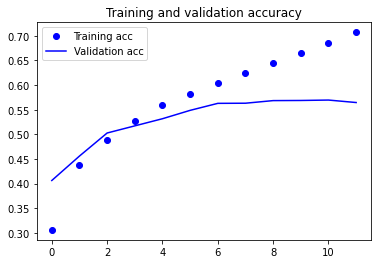

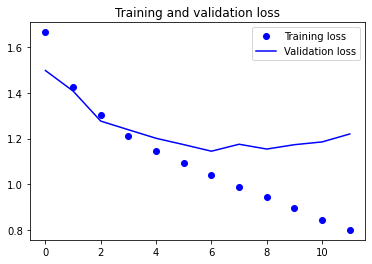

In [145]:
modelN.save('facial_2')

acc = modelF.history['accuracy']
val_acc = modelF.history['val_accuracy']
loss = modelF.history['loss']
val_loss = modelF.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [146]:
# evaluate model on private test set
score = modelN.evaluate(X, y, verbose=0)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

model accuracy: 56.09%


[[0.04629831 0.03092606 0.08194506 0.01315821 0.13183764 0.69583476]]
Detect : Neutral
Expect : Neutral


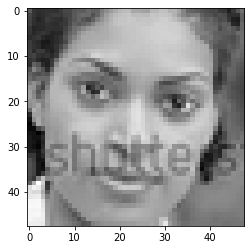

In [130]:
import random 
image = random.randint(0, len(X_test))
img = X_test[image:image+1]

y_prob = modelN.predict(img, batch_size=32, verbose=0)
index = np.argmax(y_prob)
print(y_prob)
print("Detect :", emo[index])
print("Expect :", emo[np.argmax(y_test[image:image+1])])

plt.imshow(img[0], cmap='gist_gray')
plt.show()


[[3.1191895e-24 3.9247461e-02 0.0000000e+00 9.6075255e-01 0.0000000e+00
  0.0000000e+00]]
Detect : Sad


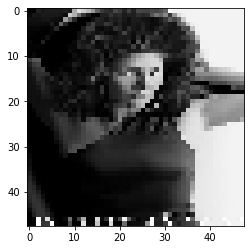

In [129]:
img = cv2.imread("../../5185055338_1dec873bf3_b.jpg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
img = img.reshape(1, 48, 48, 1)

y_prob = modelN.predict(img, batch_size=32, verbose=0)
print(y_prob)
index = np.argmax(y_prob)
print("Detect :", emo[index])

plt.imshow(img[0], cmap='gray')
plt.show()


In [137]:
X_train.shape

(28709, 48, 48, 1)